Although the notebook in Part 1 might have seemed simplistic, it is useful for determining the effectiveness and interpretability of multiple regression compared to more advanced methods. In this Jupyter notebook, we will primarily examine an exploratory and dimensional reduction technique called Principal Component Analysis (PCA). PCA transformation works especially well when variables are highly correlated, which we found was true in the previous post.

First, the following code will load and preprocess the data mentioned in the previous blog post:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline
abaloneDF = pd.read_csv('abalone.csv', names=['Sex', 'Length', 'Diameter', 'Height',
                                              'Whole Weight', 'Shucked Weight',
                                              'Viscera Weight', 'Shell Weight',
                                              'Rings'])
abaloneDF['Male'] = (abaloneDF['Sex'] == 'M').astype(int)
abaloneDF['Female'] = (abaloneDF['Sex'] == 'F').astype(int)
abaloneDF['Infant'] = (abaloneDF['Sex'] == 'I').astype(int)
abaloneDF = abaloneDF[abaloneDF['Height'] > 0]

### PCA Modeling
PCA works by transforming the axes of a dataset. For example, the original axes of a dataset might fall along X, Y, and Z; after PCA transformation, the first axis will be a linear combination of all three variables (such as X+2Y-3Z), the second axis will be orthogonal (at a right angle) to the first axis but also a linear combination of all three variables, and so on. 

New variables are created as linear combinations of the original variables. Optimal linear combinations are discovered using the eigenvectors and eigenvalues of the original data. Singular value decomposition, a technique from linear algebra, may be used to divide the original dataset into three matrices containing the eigenvalues, eigenvectors, and transformed data points of the original matrix. The eigenvectors are the transformed linear combinations, the eigenvalues describe the explained variance (informative significance) of the eigenvectors, with the highest eigenvalues being the most significant. After determining the optimal linear combinations, insignificant factors may be discarded, and the complexity of the problem is significantly reduced. 

When might PCA be useful? Variables within a dataset may lie along arbitrary axes that are not necessarily convenient for modeling, depending on how the data is collected. In many cases, more accurate models can be achieved when the choice of axes is optimized. Furthermore, some variables (or transformed axes) may be removed from consideration if they do not add a meaningful amount of information to the problem. Or PCA might be used as a data exploration technique, as it helps determine which factors typically contain the same information. 

The scikit-learn library may be used to perform PCA on the abalone dataset from the previous blog post. First, a model will be built with 10 principal components, the same as the number of variables. 

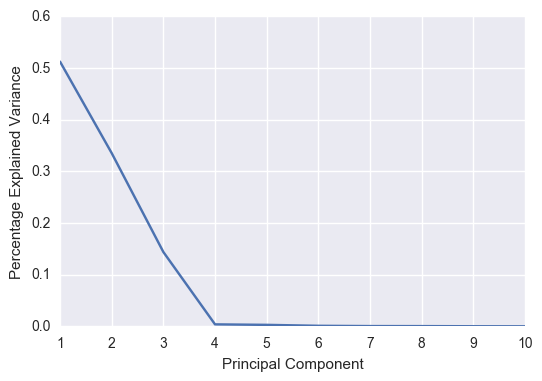

In [2]:
dataset = abaloneDF.drop(['Rings', 'Sex'],axis=1)
#We will start with the same number of components as variables
pca_model = PCA(n_components=10)
pca_model.fit(dataset)
#Plot the explained variance
plt.plot(range(1,11),pca_model.explained_variance_ratio_);
plt.xlabel('Principal Component');
plt.ylabel('Percentage Explained Variance');

According to the figure above, the majority of the variance within the model can be explained using only the first four principal components. Since we know that most of these variables are highly correlated, a good assumption is that PCs 5 through 10 contain mostly noise and can be removed from consideration. 

The following plot will illustrate the coefficients of each principal component as a combination of the original 10 variables.

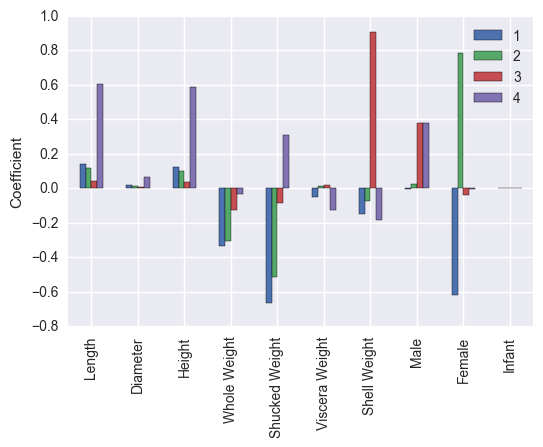

In [3]:
df = pd.DataFrame(data=pca_model.components_)
df.index = dataset.columns
dfRed = df.ix[:,0:3]
dfRed.columns = range(1,5)
dfRed.plot.bar();
plt.ylabel('Coefficient');

### Regression Modeling
Using only the first 4 principal components, which explain the majority of the variance in the dataset, a multiple regression model can be created. The following code will remove the last 6 PCs and create a regression model.

In [4]:
#Remove the last 6 PCs
red_PCA = PCA(n_components=4)
red_PCA.fit(dataset)
rings = abaloneDF['Rings'].values.reshape(len(abaloneDF),1)
red_data = np.hstack([red_PCA.transform(dataset),rings])
red_df = pd.DataFrame(red_data,columns=['PC1','PC2','PC3','PC4','Rings'])
train, test = train_test_split(red_df,train_size=0.7)
xtrain = train.drop(['Rings'],axis=1)
ytrain = train['Rings']
xtest = test.drop(['Rings'],axis=1)
ytest = test['Rings']
regr = linear_model.LinearRegression()
regr.fit(xtrain, ytrain)
#Take a look at the regression coefficients
dict(zip(list(xtrain.columns),regr.coef_))

{'PC1': 2.5132424588903874,
 'PC2': 0.3655020979543866,
 'PC3': 0.80829864756701131,
 'PC4': -23.514650429731436}

Again, let's get a sense of how well the model performed by looking at a Y-Yhat plot and some basic performance metrics:

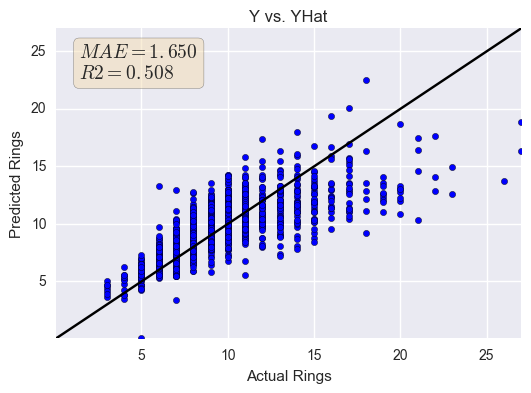

In [5]:
#Same function as in Part 1:
def plot_yyhat(ytest,ypred):
    r2 = r2_score(ytest, ypred )
    mae = mean_absolute_error(ytest, ypred)
    absmin = min([ytest.min(),ypred.min()])
    absmax = max([ytest.max(),ypred.max()])
    ax = plt.axes()
    ax.scatter(ytest,ypred)
    ax.set_title('Y vs. YHat')
    ax.axis([absmin, absmax, absmin, absmax])
    ax.plot([absmin, absmax], [absmin, absmax],c="k")
    ax.set_ylabel('Predicted Rings') 
    ax.set_xlabel('Actual Rings')
    #Plot the text box
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textStr = '$MAE=%.3f$\n$R2=%.3f$' % (mae, r2)
    ax.text(0.05, 0.95, textStr, transform=ax.transAxes, fontsize=14,
               verticalalignment='top', bbox=props);
ypred = regr.predict(xtest)
plot_yyhat(ytest,ypred)

Compare these results from those in Part 1, which achieved a best MAE of 1.563. If the PCA accuracy is not as good as multiple regression alone, why would we want to use PCA? One possibility is for visualization- if the number of variables could be reduced to 2 or 3, for example, it's easier to visualize the data points on a standard plot. In some cases, PCA may be able to significantly reduce noise in a noisy dataset by removing the PCs with the least amount of explained variance. Finally, PCA may provide better insight into the data by looking at which factors tend to be grouped into the same PC, and perhaps by giving subjective labels to the PCs.